# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Data Wrangling

### 1. Portfolio Dataset

In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [8]:
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [9]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [10]:
## Converting id column to offer_id

portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [11]:
## Converting id column to offer_id

portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


### 2. Profile Dataset

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
9,None,118,NaN
10,None,118,NaN
11,None,118,NaN
17,None,118,NaN
23,None,118,NaN


In [17]:
profile.id.nunique()

17000

In [18]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [19]:
profile.duplicated().sum()

0

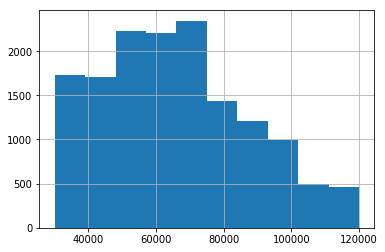

In [20]:
# distribution of income
profile.income.hist();

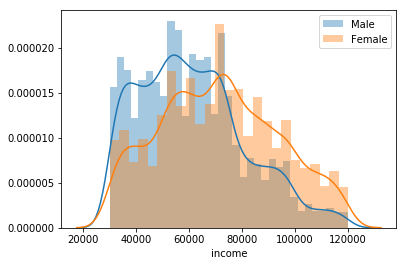

In [21]:
## Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

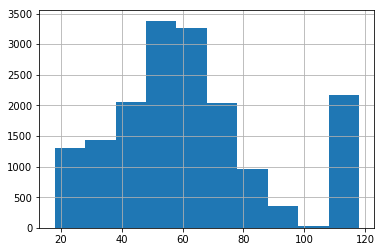

In [22]:
# age distribution
profile.age.hist();

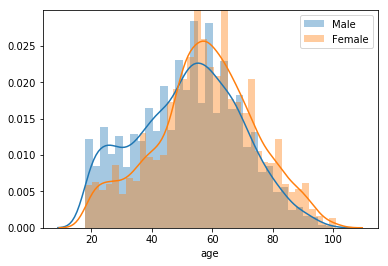

In [23]:
## Gender-wise age distribution
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
plt.legend()
plt.show()

### 3. Transcript Data

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
transcript.shape

(306534, 4)

In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [28]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [29]:
# extract the different values in value column out
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [30]:
# clean up the duplicates in offer id and offer_id and meger into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [31]:
transcript.offer_id.nunique(), transcript.person.nunique()

(10, 17000)

In [32]:
temp = pd.merge(transcript,portfolio,how='left',on='offer_id')

In [33]:
temp.groupby(['offer_type','event']).person.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: person, dtype: int64

## Defining approach for preprocessing

In order to identify the main drivers of an effective offer, I have to first define what an 'effective' offer is within the Starbucks app. For that we did some further exploration on the datasets and how all three would interact.

We know that there are 4 types of events: offer completed, offer received, offer viewed and transaction. But we have seen that our data shows we do not have any offer_id associated with transactions, because they are not recorded in the transcript event data.

Thus, the first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.
Moreover, BOGO and discount offers have an offer completed event when offers are completed. However, informational offers do not have this event associated with it. Thus,

1) For BOGO and discount offer, an effective offer is one if the following events are recorded in the right sequence in time:

offer received -> offer viewed -> transaction -> offer completed

2) For an informational offer, effective offer:

offer received -> offer viewed -> transaction

In [34]:
# quick view on event distribution by offer_type by combining two dataset (portfolio, transcript)
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

## Data Processing

a. Assigning offer ids to transactions
We now have to assign offer_ids to specific transactions as there is no offer id associated with transactions.

We can define all our customers into 4 main groups:

1. People who are influenced and successfully complete - effective offers:

 - `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
 - `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

2. People who received and viewed an offer but did not successfully complete - ineffective offers:

 - `offer received` -> `offer viewed`

3. People who purchase/complete offers regardless of awareness of any offers:

 - `transaction`
 - `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
 - `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
 - `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
 - `offer received` -> `transaction` (informational offers)
 - `offer received` -> `transaction` -> `offer viewed` (informational offers)
 
 I would have to separate out the people in group 2 from people in group 4, as people in group 2 may have viewed an offer but did not take any action, whereas people in group 4 did not even have an offer viewed event.

Separating the people of group 1 (effective offers) and people who purchase/complete offers regardless of awareness of any offers (group 3) is particularly tricky. For people in group 3, a conversion is invalid (i.e., not a successful conversion from an offer) if an offer completed or transaction occurs before an offer viewed. There also may be scenarios where an offer completed occurs after the offer is viewed, but a transaction was done prior to the offer being viewed. In this instance, the offer may have been completed, but it is also not a valid conversion.

### Defining the target variable effective offer:

We know that group 1 customers will be our target variable "effective_offer" = 1, but there are many ineffective offer definitions for groups 2-4.

So what would we define as an ineffective offer? As already stated above, group 2 would be within our definition of an ineffective offer; where a user is aware of an offer, but the offer is ineffective as it does not convert the user into a customer. So group 2 can be defined as our target variable "effective_offer" = 0.

What about group 3 and group 4? Group 3 consists of users who may have received offers but would have purchased regardless. From the business point of view, we would not want to be sending them any offers.

Meanwhile, group 4 users would be considered low priority customers, as they do not do any action, regardless of whether they receive offers or not.

So, we can deprioritise group 3 and group 4 users from our model.

The conditions above are the basis of which I can assign the offer id that 'influences' a transaction by ensuring that the transaction occurs after an offer viewed event.

After sorting the transcript dataset by person and time to ensure that each event for each person occurs in sequence, we filter the dataset by events offer viewed and transaction to ensure that it only contains those events in order.

Then, we use pandas' ffill() method to fill every transaction with the offer_id of the viewed offer, only if it occurs before the transaction.

Since offer_id is not associated with any 'transaction' event, in order to flag whether the offer has been finally completed with a transaction, here we need to link the offer id back to all transaction events. For BOGO and discount offer, both of them will have the consequence of offer received, viewed, transaction and offer completed which will apparently show that the offer is redeemed and should definitely be sent out. For the informational offer, though there's no reward step there should still be a transaction which is linked to the usage of the offer.

In [35]:

# drop the useless columns
transcript_processed = pd.DataFrame(transcript)

transcript_processed = transcript_processed.drop(columns=['reward_x','reward_y'], axis=1,inplace=False)
transcript_processed.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo


In [36]:
# sort the events by person and time
transcript_processed = transcript_processed.sort_values(['person','time'])
transcript_processed.head(5)

,event,person,time,value,amount,offer_id,channels,difficulty,duration,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [37]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = transcript_processed[['time','offer_id','person','event']][(transcript_processed['event']\
    =='transaction') | (transcript_processed['event']=='offer viewed')]
offer_completed.update(offer_completed.groupby(['person']).ffill())
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [38]:
#Since the above temporary dataset is just a subset of the transcript dataset, I can create a new dataset with the filled in offer ids for transactions.
transcript_processed = transcript_processed.merge(offer_completed, how='left', on=['person','time','event'])
transcript_processed.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [39]:
# clean up the dataframe (removing the dummy columns)
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'].isnull(),\
                                            transcript_processed['offer_id_y'], transcript_processed['offer_id_x'])
transcript_processed.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [40]:
#merge portfolio dataset to get offer data
transcript_processed = transcript_processed.merge(portfolio, how = 'left',on='offer_id')
transcript_processed['duration'] = np.where(transcript_processed['duration_x'].isnull(), \
                                            transcript_processed['duration_y'], transcript_processed['duration_x'])
transcript_processed.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],\
                         axis=1, inplace=True)
transcript_processed.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

#### b. Flagging transactions and offers completed after offers viewed

The next important step for preparing our data for modeling and analysis is to identify a completed offer and transactions occurring after an offer is viewed.

Once we have assigned a transaction occurring after an offer is viewed, I can use that information to subset my data according to the groups defined above, and analyse within each group.

Since we've already filled all transaction's offer id, we can extract the transactions converted from offers by checking if the offer id before the transaction is the same as the transaction's offer id.

This means that as long as the events offer viewed,transaction, and offer completed occur in the same event space and are in the corrrect sequence of time, we can be assured that it is a transaction and/or completed offer occurring only after an offer is viewed.

To do this, I created a new column to flag the previous offer id using pandas' shift function.

In [41]:
# subset the dataset with only offer viewed, transaction, and offer completed events
transactions_after_viewed = transcript_processed[(transcript_processed['event']=='offer viewed')|\
                                                 (transcript_processed['event']=='transaction')|\
                                                 (transcript_processed['event']=='offer completed')].copy()

# generate the previous offer id
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()

# create flag for responsed offer which competed after customer viewing the offer
transactions_after_viewed['completed_offer'] = np.where(transactions_after_viewed['pre_offer_id']==\
                                                       transactions_after_viewed['offer_id'],1,0)

In [42]:
# join back the 'offer received' events which was filtered out in the previous step
offer_received = transcript_processed[transcript_processed['event']=='offer received']

offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

transcript_processed = offer_received.append(transactions_after_viewed).sort_values(['person','time'])
transcript_processed.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0


Since the different offer has difference consequence of completion, for example, for the informational offer, there'll not be rewards. Therefore, separate the transcript data by offer type for easier analysis.

In [43]:
#split transcript into 3 different offer types
bogo = transcript_processed[transcript_processed['offer_type']=='bogo'].copy()
discount = transcript_processed[transcript_processed['offer_type']=='discount'].copy()
informational = transcript_processed[transcript_processed['offer_type']=='informational'].copy()

Within each offer type, we can already successfully separate every unique person-offer_id in group 1 from the others using our completed_offer column. Since we have flagged all conversion events (transaction or offer completed event depending on offer type) occurring after an offer viewed event, we can be assured that whichever conversion events are flagged with valid_completed=1 are at least within the first group (People who are influenced and successfully convert - effective offers).

For BOGO and discount offers, we will only consider offer completed events as the conversion events, while we can consider transaction event as the conversion event for the informational offers.

In [44]:
## Defining Group1 peoples

bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()

Meanwhile, for informational offers we will define group 1 later as there is an additional consideration we need to take into account for transactions - they need to occur within the validity period of an informational offer for us to consider them as effective offers

Now, we can look into separating group 2 and group 4 unique person-offer_ids for BOGO and discount offers. We can assume that every person who views an offer would have had an offer received event prior, so we can just take the whole group of people who received an offer and subset them into group 2 and 4 later.

In [45]:
#again, we define a function as we will repeat this for 2 datasets - BOGO & discount
def not_converted(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people of group2 and group4.
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unique person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events (transaction and offer_completed)
       
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

#check how many are in either group
check_merge_bogo=not_converted(bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=not_converted(discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


There are fair number of unique person-offer_id pairs that have offer received events, but no conversion events. These would be considered offers in group 2 and 4 within each offer type.

Then, based on merged dataset above, we can seperate out customers who only viewed the offer after they received the offer and customers who didn't even open the offer after they receive the offer.

In [46]:
grp_2_4_bogo = check_merge_bogo[check_merge_bogo['_merge'] == 'right_only']
grp_2_4_bogo  = grp_2_4_bogo.merge(transcript_processed,how='left',on=['person','offer_id'])
grp_2_bogo = grp_2_4_bogo[['person','offer_id']][grp_2_4_bogo['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_bogo.drop(['_merge'], axis=1, inplace=True)
grp_4_bogo=grp_2_4_bogo.merge(grp_2_bogo[['person','offer_id']],how='left',indicator=True)
grp_4_bogo=grp_4_bogo[grp_4_bogo['_merge']=='left_only'].copy()

In [47]:
# do the same action on discount offer

# subtract the customers who received the offer without finishing the transaction
grp_2_4_discount = check_merge_discount[check_merge_discount['_merge']=='right_only']
grp_2_4_discount = grp_2_4_discount.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only viewed the offer and people who viewed the offer but didn't make transaction
grp_2_discount = grp_2_4_discount[['person','offer_id']][grp_2_4_discount['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
grp_2_4_discount.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
grp_4_discount = grp_2_4_discount.merge(grp_2_discount[['person','offer_id']], how='left', indicator=True)
grp_4_discount = grp_4_discount[grp_4_discount['_merge']=='left_only'].copy()

Group 3 people are everyone in the converted ids who do not have an offer viewed prior - hence, they would be people with transaction and offer_completed events but no offer viewed event prior. For BOGO and discount offers, they would be people with offer completed events that have completed_offer != 1.

In [48]:
# subset the offer which has no correction with offer
grp3_bogo = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
grp3_discount = discount[['person','offer_id']][(discount['event']=='offer completed')\
                    & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

Next, we have to consider the effective and ineffective offers depending on the group type. As already elaborated above, any unique person-offer_id belonging to group 1 can be considered in our target variable effective_offer=1 group.Meanwhile, group 2 is in our target variable effective_offer=0 group.

In [49]:
def final_offers_dataset(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

offers_bogo=final_offers_dataset(bogo_completed,grp_2_bogo)
offers_discount=final_offers_dataset(discount_completed,grp_2_discount)

Now we have successfully prepared the target variables for our BOGO and discount datasets.

Meanwhile, for informational offers in particular, before we can tag the effective offers column, there is one more consideration - the validity of the offer.

#### c. Considering duration of offers for informational offers to mark them as converted

There is an additional rule to consider when considering an effective/converted transaction and offer for 'informational' type offers. The reason why informational offers get a different treatment is because the conversion event is not an offer completed event, but a transaction.

An offer should only be considered effective if it is within the duration of the offer.

As we saw in our data dictionary, the time of an event in the transcript data is in terms of hours. In order to ensure it is on the same scale as the duration of the offer, we have to convert it into days.

We convert the time data in informational offers to be in days as it is days in case of offers dataset

In [50]:
#convert time into days
informational['day_offer']=informational['time']/24
#drop unnecessary columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)

In [51]:
#sort transactions to ensure all events occurring by person and offer
informational=informational.sort_values(['person','day_offer','event','offer_id'])

We can get the difference between two events using the diff function in pandas. We take the difference between the transaction and the offer received as the duration.

In [52]:
#get difference in time for informational offers
informational['diff']=informational[(informational['offer_type']=='informational') & ((informational['event']=='offer received') | (informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [53]:

#create column for flagging valid events
informational['valid_completed_duration']=np.nan
#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completed_duration']=1
#fill any missing values with 0 flag
informational['valid_completed_duration']=informational['valid_completed_duration'].fillna(value=0)

With the completed_offer and valid_completed_duration flag columns, we have 4 possible scenarios for an informational offer:

Only Scenario 3 will be considered as label effective_offers = 1 i.e Group 1

Meanwhile, Scenarios 1 and 2 can be considered into our Group 3 of customers - People who purchase/complete offers regardless of awareness of any offers.

In Scenario 1, even though according to our completed_offer flag, they had viewed an offer prior to the transaction, but it is not within the duration, thus they are not 'influenced' by the offer.

In Scenario 2, customers are in Group 3 as they completed transactions without viewing an offer.

Scenario 4 can be considered in group 4, as they only consist of transactions.

In [54]:
#flag effective_offers where completed_offer = 1 and valid_completed_duration = 1
informational['offer_responded']=np.where(((informational['completed_offer']==1)\
                                           & (informational['valid_completed_duration']==1)),1,0)

In [55]:
#separate group 1 in transcript_into
info_completed = informational[['person','offer_id']][informational['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

In [56]:
#separate out group 2 of customers
check_merge_info=not_converted(informational)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [57]:
grp_2_4_info = check_merge_info[check_merge_info['_merge'] == 'right_only']
grp_2_4_info  = grp_2_4_info.merge(transcript_processed,how='left',on=['person','offer_id'])
grp_2_info = grp_2_4_info[['person','offer_id']][grp_2_4_info['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_info.drop(['_merge'], axis=1, inplace=True)
grp_4_info=grp_2_4_info.merge(grp_2_info[['person','offer_id']],how='left',indicator=True)
grp_4_info=grp_4_info[grp_4_info['_merge']=='left_only'].copy()

For group 3, we have to consider those with conversions who do not have an offer viewed prior - hence, they would be people with conversion events but no offer viewed event prior. For informational offers, these would be transactions in Scenario 1 and 2 above.

In [58]:
#scenario 1
grp3_1=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']!=1) & (informational['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']==1) & (informational['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp_3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

Now we can append the datasets together to make the offers_info dataset, ready for modeling.

In [59]:
offers_info=final_offers_dataset(info_completed,grp_2_info)

Now that we have subset all our datasets into effective and ineffective offers depending on offer type, we can append the datasets accordingly into datasets for modeling.

### Feature Engineering

Now we have to look into the features and see how to be creative in creating new features.

#### i. became_member_on column to be engineered

The became_member_on column were in date format. Hence in order to extract meaningful insights from that feature, we can convert it as a feature indicating tenure of membership. This can have some effect on predicting whether the customer will take up an offer or not

In [60]:
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def member_since(df):
    '''
    inputs:
    - df: dataframe to generate the length of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-4:-2]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

offers_bogo=member_since(offers_bogo)
offers_discount=member_since(offers_discount)
offers_info=member_since(offers_info)

#### ii. Count of offers received
As part of some further data exploration, I discovered that there could be multiple offers received per person. The no of times each offers received by customer also can have effect on offers being effective or not.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


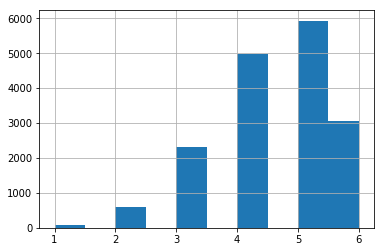

In [61]:
#group event=offer received per person in transactional records
print(transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().hist();

We can see above that the offer received per person in the transactional data could range from 1 to 6 offers received. I had the hypothesis that the frequency of offers received per person might result in more effective offers, so decided to engineer a feature offer_received_cnt to account for this frequency.

In [62]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript_processed[transcript_processed['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
df_offer_received_cnt.drop(['time'], axis=1, inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

#### iii. Subtract the transactions which's not related to the offer
I also wondered how many transactions were considered 'invalid' by my definition. Ordinarily, these would be the sum of transactions done by people not in group 1. The objective of offers are to drive purchases, so it would already be the case that users with high spend in their transactions would be flagged as effective_offers.

We've already defined that there are people in groups 3 and 4, where they are separate pools of users who are loyal spenders, and already tend to purchase more, isolated from the the effect of offers.

But for users in group 1 have a high amount of 'invalid spend' outside of the effect of offers, there might be some predictive power onto the effectiveness of offers; since a loyal user might have a higher tendency of taking up an offer.

In my datasets, I had already separated the transactions who are conversions versus transactions who are just the users' normal purchasing behaviour. This is through the completed_offer column, where I checked if a transaction had an offer viewed event prior.

In the cases where offer_completed=1, I had already included them in my effective offers flag for BOGO and Discount offers. However, for those transctions where offer_completed=0, I have not considered them, and this could be a potential feature to include, as a proxy for the 'baseline' level of spending for a user.

The logic is to wonder if there is some baseline level of spending for users who are highly influenced by certain offers (in group 1), and group 2, and if there is some predictive power in this baseline level of 'invalid transactions' that can predict the propensity of a user to take up an offer.

In [63]:
#filter dataset by invalid transactions
# subtract the transactions which's not related to the offer
transactions_not_related=transcript_processed[(transcript_processed['event']=='transaction') & (transcript_processed['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

### Preparing data for implementation
Now we can finally begin with preparing the data for modeling.

a. Merge with temporary datasets created above to include engineered features

b. Drop missing values in gender,income and abnormal age value column for demographic data; convert gender into dummy variables

c. Separate the channel column into categorical variables

d. Treatment of duplicate records

#### a. Merge with temporary datasets created above to include engineered features

In [64]:
# merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

#### b. Drop missing values in gender column for demographic data
Now, we need to check whether dropping the missing values will result in a significant loss in data.

In [65]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid        96.323752
income                 7.057489
gender                 7.057489
offer_received_cnt     0.000000
membership_days        0.000000
dtype: float64

We can see that amount_invalid column has 97% missing data. Since it is so 'sparse' for BOGO offers, it might not have much information after all. We assess this feature again later during the model implementation phase. For now, we fill the missing amount_invalid column with 0.

Meanwhile, we drop the income and gender columns as they are not useful when they are null.

In [66]:
# fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)
offers_bogo.dropna(inplace=True)

#### c. Separate the channel column into categorical variables

In [67]:
#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=df.drop(columns=col,axis=1,inplace=False)
    return df

In [68]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
for index, row in offers_bogo.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_bogo.loc[index, 'channels']:
            offers_bogo.loc[index, channel] = 1
        else:
            offers_bogo.loc[index, channel] = 0


In [69]:
offers_bogo = offers_bogo.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

In [70]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',on='offer_id')

    #convert channels into categorical variables
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in df.loc[index, 'channels']:
                df.loc[index, channel] = 1
            else:
                df.loc[index, channel] = 0
    df = df.drop(['channels'], axis=1, inplace=False)
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [71]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

In [72]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info = offers_info.reset_index().drop(['index'],axis=1,inplace=False)


#convert channels into categorical variables
for index, row in offers_info.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_info.loc[index, 'channels']:
            offers_info.loc[index, channel] = 1
        else:
            offers_info.loc[index, channel] = 0
offers_info = offers_info.drop(['channels'], axis=1, inplace=False)


In [73]:
#repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

In [74]:
offers_info=prep_offers_df(offers_info)
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_days,difficulty,duration,offer_type,reward,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,1071.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,1.0,0.00,1,0,0


## Implementation

Now that the datasets are ready, we can proceed to implementing the model. Our target feature is effective_offer

Since we have 3 offer types, there are thus 3 different models to be built. This is effectively a binary classification supervised learning model.

I decided to compare the performance of a simple decision tree classifier model as a baseline model, with an ensemble random forest classifier model. Reason for which we selected tree based models because we also want interpretability of the model. And this project also attempts to predict whether the customer will respond to the different types of offers or not.

Meanwhile, I also selected random forest as an alternate model to compare the baseline model with. Random Forest is an ensemble bagging of decision trees, which aim towards a high accuracy in training the model.

Before we can proceed, we have to make sure that the classes we are predicting for are balanced in each dataset.

In [75]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


We can see that the classes are quite uneven for all three offer types, but not too imbalanced such that it would pose a problem. Hence, we can proceed to implement the models.

A note on model evaluation and validation; since the classes for the all 3 models are imbalanced, I decided to implement both accuracy and f1 score as the model evaluation metric. F1 score provides a better sense of model performance compared to purely accuracy as it takes both false positives and false negatives in the calculation. With an uneven class distribution, F1 may usually be more useful than accuracy.

F1 score gives more weightage to true positive and hence for the Starbucks app here, it would be fine as we would prioritise more on whether offers are effective, and less focus on why offers are ineffective.

#### a. Model Implementation
We are creating 3 models to predict the effectiveness of an offer within each type, depending on offer attributes and user demographics.

First, we have to define our target and features variables.

In [76]:
def data_prep(df,col_drop):
    '''
    inputs:
    - df: prepared dataframe for modeling and columns to be dropped
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = df.drop(columns = col_drop,inplace=False,axis=1)
    return features,target

Next, I split the data into training and test sets. Since the features of my data are all on different scales, I also apply a scaler to ensure my data will all be on the same scale for training.

In [77]:
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

I am defining the functions here to run my model as I plan to implement 3 different models; hence it would be easier to implement repeatedly. In this function, I define the model scores - F1 score and accuracy, as well as the error (mean squared error).

In [78]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test)
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [79]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### i. BOGO offers model
First we try to build the BOGO offers model. I initialize the models with some randomly chosen parameters to check the initial performance. If performance needs to be improved further, I will attempt Grid Search to find the optimal parameters.

In [80]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy:0.8223
Test accuracy:0.8218
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       438
          1     0.8218    1.0000    0.9022      2020

avg / total     0.6754    0.8218    0.7414      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1626
MSE_test: 0.1733

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Training accuracy:0.8374
Test accuracy:0.8267
             precision    recall  f1-score   support

          0     0.5732    0.1073    0.1808       438
          1     0.8354    0.9827    0.9031      2020

avg / total     0.7887    0.8267    0.7744      2458



The accuracy for Random Forest Classifier (RF) model actually ends up outperforming the Decision Tree Classifier (DT) model slightly, but overall the performance for both models is about the same (82.83% vs 82.18% respectively in terms of accuracy). Accuracy for a first attempt is quite good, more than 80%. We will try tuning the model for better accuracy

However, in terms of the F1 score, both models are below 80%, with the Random Forest model performing better compared to the Decision Tree Classifier, with 76.70% vs. 74.14%.

The results would indicate that RF model is doing slightly better compared to DT at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).

Our model is predicting the positive case (i.e. where an offer is effective) more accurately compared to predicting the negative cases (i.e. where an offer is ineffective), which is expected given the uneven classes. We are perhaps not as concerned with these misclassification since we don't mind sending people more offers than they would have liked; we would rather not miss anyone on which an offer would have been effective.

Given this case, I will go with the RF model.

Since I aim to analyse the drivers of an effective offer, I will check the feature importances for the models after I have selected the best model from refinement.


#### ii. Discount offers model
I repeat the same steps above but with my offer_discounts dataset.

In [81]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1271
MSE_test: 0.1265
Training accuracy:0.8729
Test accuracy:0.8735
             precision    recall  f1-score   support

          0     0.5652    0.0400    0.0747       325
          1     0.8763    0.9955    0.9321      2220

avg / total     0.8366    0.8735    0.8226      2545



This time, the Decision Tree Classifier model also has a better performance compared to the Random Forest Classifier in terms of accuracy (87.07% vs 87.23%), and the F1 score is also lower (81.71% vs 81.28%).

In [82]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
             precision    recall  f1-score   support

          0     0.4722    0.1915    0.2725       355
          1     0.7709    0.9271    0.8418      1042

avg / total     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2299
MSE_test: 0.2541
Training accuracy:0.7701
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.0845    0.1446       355
          1     0.7569    0.9712    0.8508      1042

avg / total     0.6916    0.7459    0.6713      1397



The performance for these models are worse compared to the other 2 datasets, with accuracy below 80% for both models, but RF model still performing better. The F1 score is also worse, at 68.23% RF Classifier, worse than the DT model at 69.72%.

One potential reason for the worse performance is perhaps due to the fact that I had the key assumption to assign the conversion events to be transactions that only occur after an offer is viewed and within the specified duration; I might have missed out on some valuable information by removing those transactions that occur regardless. We can see this from how the overall sample dataset is smaller (about half) the datasets for the other 2 offers, with only about 5K samples compared to about 10K for both BOGO and discount respectively.

### b. Refinement
In refining the model, I will first try parameter tuning for the 3 RF models, before experimenting with removing or adding features to improve model performance.

In [83]:
#define function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

#### i. Grid Search to discover optimal parameters
I decided to do GridSearch to determine what would be the optimal parameters for the model.

For all three offers, the Random Forest model had relatively good performance, so I used Grid Search on this to determine the best parameters.

In [84]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [85]:
#define BOGO dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 40}

Now that we have the optimal parameters for the BOGO model, I run my model again with the new parameters, keeping the DecisionTree baseline model with the same parameters as comparison.

In [86]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy:0.8223
Test accuracy:0.8218
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       438
          1     0.8218    1.0000    0.9022      2020

avg / total     0.6754    0.8218    0.7414      2458



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1549
MSE_test: 0.1701
Training accuracy:0.8451
Test accuracy:0.8299
             precision    recall  f1-score   support

          0     0.6190    0.1187    0.1992       438
          1     0.8374    0.9842    0.9049      2020

avg / total     0.7985    0.8299    0.7791      2458



In [87]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.029245,0.042611
testing_score,0.826688,0.829943
train_time,0.133965,0.181749
training_score,0.837420,0.845050


In [88]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.042611,0.829943,0.181749,0.84505


The accuracy for the RF model increased slightly - from 82.8316% to 82.8723%, and the F1 score increased from 76.70% to 77.57%. This is a good performance increase but minimal, which indicates that perhaps there's not much that can be done to improve the performance of the model with parameter tuning.

So I will have to explore other avenues with the features to improve the performance of the model further.

In [89]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 40}

In [90]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1274
MSE_test: 0.1273
Training accuracy:0.8726
Test accuracy:0.8727
             precision    recall  f1-score   support

          0     0.5238    0.0338    0.0636       325
          1     0.8756    0.9955    0.9317      2220

avg / total     0.8307    0.8727    0.8208      2545



In [91]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.034114,0.046116
testing_score,0.873477,0.872692
train_time,0.156826,0.231287
training_score,0.872876,0.872581


In [92]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_1,0.034114,0.873477,0.156826,0.872876


The accuracy of the model increaased slightly, from 87.07% to 87.39%, and the F1 score improved from 81.71% to 82.08%. The good thing is that now both the accuracy and the F1 score for the RF model is better than the DT model.

But because the increase was minimal, again we can conclude that tuning the parameters won't really improve the performance of the model significantly.

In [93]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 25}

In [94]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)


DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
             precision    recall  f1-score   support

          0     0.4722    0.1915    0.2725       355
          1     0.7709    0.9271    0.8418      1042

avg / total     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2474
MSE_test: 0.2477
Training accuracy:0.7526
Test accuracy:0.7523
             precision    recall  f1-score   support

          0     0.6286    0.0620    0.1128       355
          1     0.7555    0.9875    0.8561      1042

avg / total     0.7233    0.7523    0.6672      1397



In [95]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.018725,0.020820
testing_score,0.745884,0.752326
train_time,0.089295,0.099143
training_score,0.770098,0.752551


In [96]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.02082,0.752326,0.099143,0.752551


Again we see some improvement in accuracy for RF model, from 74.87% to 75.23%, and slight decrease in F1 score from 68.23% to 67.14%. This improvement is minimal,so we look into improving the feature selection of the model.

#### ii. Removing sparse features e.g. amount_invalid¶
In terms of feature selection, I wanted to try and see if removing the amount_invalid variable, which we had noted as being sparse, hence may not be useful in predicting the effectiveness of offers, would help.

I removed the feature from my data prep and retrained the model using the same optimal parameters found via GridSearch, with the DT model as a baseline

In [97]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)


DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1764
MSE_test: 0.1745
Training accuracy:0.8236
Test accuracy:0.8255
             precision    recall  f1-score   support

          0     0.5283    0.1918    0.2814       438
          1     0.8460    0.9629    0.9007      2020

avg / total     0.7894    0.8255    0.7903      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1552
MSE_test: 0.1705
Training accuracy:0.8448
Test accuracy:0.8295
             precision    recall  f1-score   support

          0     0.6267    0.1073    0.1832       438
          1     0.8359    0.9861    0.9048      2020

avg / total     0.7986    0.8295    0.7763      2458



In [98]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.042611,0.039571
testing_score,0.829943,0.829536
train_time,0.181749,0.184620
training_score,0.845050,0.844847


In [99]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.042611,0.829943,0.181749,0.84505


Model accuracy and F1 score did remain the same, so I wont leave the amount_invalid feature out of my model.

In [100]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1242
MSE_test: 0.1277
Training accuracy:0.8758
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0338    0.0634       325
          1     0.8755    0.9950    0.9315      2220

avg / total     0.8276    0.8723    0.8206      2545



In [101]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.046116,0.047891
testing_score,0.872692,0.872299
train_time,0.231287,0.232513
training_score,0.872581,0.875823


In [102]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_1,0.034114,0.873477,0.156826,0.872876


In [103]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
             precision    recall  f1-score   support

          0     0.4722    0.1915    0.2725       355
          1     0.7709    0.9271    0.8418      1042

avg / total     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2440
MSE_test: 0.2470
Training accuracy:0.7560
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.6087    0.0789    0.1397       355
          1     0.7580    0.9827    0.8558      1042

avg / total     0.7200    0.7530    0.6738      1397



In [104]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.020820,0.023842
testing_score,0.752326,0.753042
train_time,0.099143,0.099481
training_score,0.752551,0.755953


In [105]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_3,0.023842,0.753042,0.099481,0.755953


Accuracy and F1 score of the model actually increased here for info model but not to much extent, so I will also keep the feature in.

#### iv. Discussion on best models and feature importances:
Now that I am done with refining the 3 models, we can check the results for our best models for all 3 and check the feature importances to see the top drivers of effectiveness of offers.

In [106]:
#get best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_1,RandomForestClassifier_info_3
pred_time,0.042611,0.034114,0.023842
testing_score,0.829943,0.873477,0.753042
train_time,0.181749,0.156826,0.099481
training_score,0.845050,0.872876,0.755953


Overall, we can see that the top performing models are the 2nd model (with GridSearch to find optimal model parameters and removing amount_invalid column) for predicting effectiveness of BOGO and discount offers, and informational offers.

In order to find the most influential drivers of an effective offer, we can check the feature importances of our best models above.

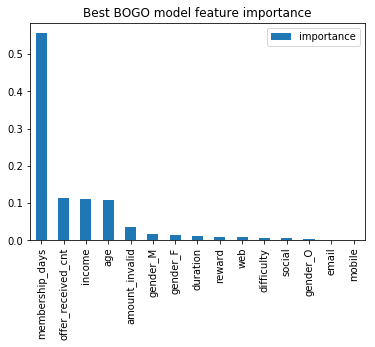

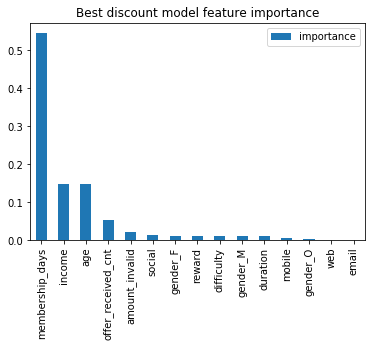

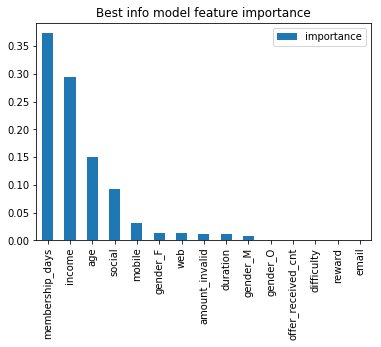

In [107]:
#show feature importance
#BOGO 3 model
#prepare data same as BOGO 3 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount 3 model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#info_2 model
#prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

Checking on the feature importance to analyse the main drivers of an effective offer, we can see that the most important driver of effective offers across all three are the tenure of membership i.e. the longer the customer as a member of Starbucks, the more likely (s)he will respond to the offer they receive. And, the 2nd most important feature is income for each of the three models.

For a BOGO offer, the membership tenure is the most important feature, and the other variables are a lot smaller in proportions. Income, age and offer_received_cnt are the 2nd, 3rd and 4th most important features, but their proportions are very small.

For a discount offer, after the membership tenure, age and income are the next most important variables. But it is still very small in proportions.

The feature importances for the informational offer models are more distributed compared to the BOGO and discount models, with income being the 2nd most important feature. Age is the third and social channel interestingly being the 4th.

## Conclusion
Overall, I found this project challenging, mainly due to the structure of the data in the transcript dataset. I had started out with 2 business questions:

What are the main features influencing the effectiveness of an offer on the Starbucks app?
Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?
### a. Reflection:

#### i. Question 1 findings:
For Question 1, the feature importance given by all 3 models were that the tenure of a member is the biggest predictor of the effectiveness of an offer.

For all three models, the top 3 variables were the same - membership tenure, income and age. However, income and age switched orders depending on offer type.

For BOGO and discount offers, the distribution of feature importances were relatively equal. However, for informational offers, the distribution is slightly more balanced, with income the second most important variable.

#### ii. Question 2 findings:
My decision to use 3 separate models to predict the effectiveness of each offer type ended up with good accuracy for the BOGO and discount models (82.87% for BOGO and 87.38% for discount), while slightly less accurate performance for informational offers (75.23%). However, I would regard 75% as acceptable in a business setting, as for informational offers, there is no cost involved to inform users of a product.

Meanwhile, for BOGO and discount models, I am quite happy with the 80% and above accuracy, as in a business setting that would be acceptable to show offers to people, even if the model misclassifies a few, the overall revenue increase might justify the few mistakes.

### b. Main challenges and potential improvement:
When analysing and building the machine learning models to answer the above questions, reflections on my main challenges and findings are as follows:

#### i. Attribution framework for assigning offer_ids for transactions:
In order to answer Question 1, I had to first define what an 'effective offer' means using the transactional records. This proved to be the trickiest portion of the project. I had to define a funnel for what what an effective conversion would look like, as we had data on both effective and noneffective conversions. Thus, I was desigining an attribution model for the conversion events (offer completed and transaction events) based on the events that occurred prior for each person.

I ended up having to separate the users into 4 different pools, based on their actions in the transcript data:

Group 1: People who are influenced by offers and thus purchase/complete the offer(successful/effective conversion of offer)
Group 2: People who receive and an offer but is not influenced and thus no conversion event (ineffective conversion of offer)
Group 3: People who have conversion events but was not actually influenced by an offer
Group 4: People who receive offers but no views or action taken
Even after separating the groups, it was challenging to assign the people in group 3 based on the transactional data. I had to define the event space where the right sequence of events would occur before I could assign an offer id to transactions (which did not have an offer_id), essentally designing a event/sequence-based attribution window.

#### ii. Feature engineering:
Deciding on what features to re-engineer and how to engineer for an effective model. At the end, our reengineered feature of membership tenure was indeed the most important feature.

#### iii. Model implementation decisions:
I had made the decision to build 3 separate models depending on offer types based on my definition of the problem statement - as I wanted to discover what would drive an effective offer, I thought it made more sense to remove noise from the data by separating the data into the offer types. My decision ended up to be quite a good one as the single BOGO and discount models got good performance in testing scores.

For the info model, the accuracy was slightly worse as we had less records overall. As elaborated above, I believe that if we had more data, I could have gotten the accuracy higher.

An additional note on model selection - I selected tree-based models as I wanted to assess feature importance, but I could have extended this study further by testing a parametric/ regression model (e.g. logistic regression for classification tasks). The weights of the coefficients from a regression model might have been interesting to contrast with the feature importance of a tree-based model, given that both models have different ways of analysing the data. The feature membership_tenure_days might not have been the highest weighted feature, in contrast to how it was in this study.

## Further Improvements and Experimentation
Due to time reasons, I couldn't get a chance to try some other enhancement in the step of model tuning. For example, probably, I can do some more experiment on feature engineering step to see if any other new features can improve the model, also I could also try to reduce some feature to see how it will affect the model performance.

Also, so far the analysis is focused more on customer's who successfully finish the transaction after they received the offer, there should be more insight for the other cases where the customer finishes the transactions regardless of the offer. If we could get any insight into those cases, maybe we can send out more offers to those customers.

In addition, I was thinking if I could do some unsupervised learning on clustering the customers based on information we are given, to see if there are any specific characteristics on a group of customers who will be more likely to respond to the offer.